In [4]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
import Models 
from train_test_validat import *
from self_attention import *
from  ecg_get_data import *
import ECGplot

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_path =  '/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN/npy_ECG/' #路径
lable_path = '/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN/label.npy'
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x = load_data(data_path,EcgChannles_num=EcgChannles_num,EcgLength_num=EcgLength_num)
y = load_label(lable_path)

100%|██████████| 1698/1698 [00:04<00:00, 402.97it/s]


In [6]:
test_model_path = "/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN/model/20220907_105710/best_model_0.pt"
test_model = torch.load(test_model_path).to(DEVICE)
test_x = x[1:2]
test_y = y[1:2]
test_x = MAX_MIN_normalization_by_feactures(test_x)
test_x = torch.FloatTensor(test_x)  #turn numpy to tensor
test_y = torch.LongTensor(test_y)
test_dataset = Data.TensorDataset(test_x, test_y)
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
test_model.eval()
attention_value_timestep = np.zeros(312,)
for i,data in enumerate(test_dataloader,0):
    inputs,labels = data[0].to(DEVICE),data[1].to(DEVICE)
    outputs = test_model(inputs)
    #print(labels)
    _,pred = outputs.max(1) # 求概率最大值对应的标签
    print("the label :{labels},pred is {pred}".format(labels=labels[0],pred=pred[0]))
    attention_value = test_model.attention_value
    attention_value_timestep += (((attention_value.to('cpu'))[0]).detach().numpy()).sum(axis=0) #将得到的attention值(5000,5000)每行叠加起来，得到（5000，）的attention值

the label :1,pred is 1


In [7]:
x_index = np.arange(0,EcgLength_num)
attention_value__each_timestep = np.zeros(EcgLength_num,)
factor = int(EcgLength_num/len(attention_value_timestep))
for i in range(0,EcgLength_num,factor):
    if (i/factor)>=len(attention_value_timestep):
        break
    attention_value__each_timestep[i:i+factor] = attention_value_timestep[int(i/factor)]

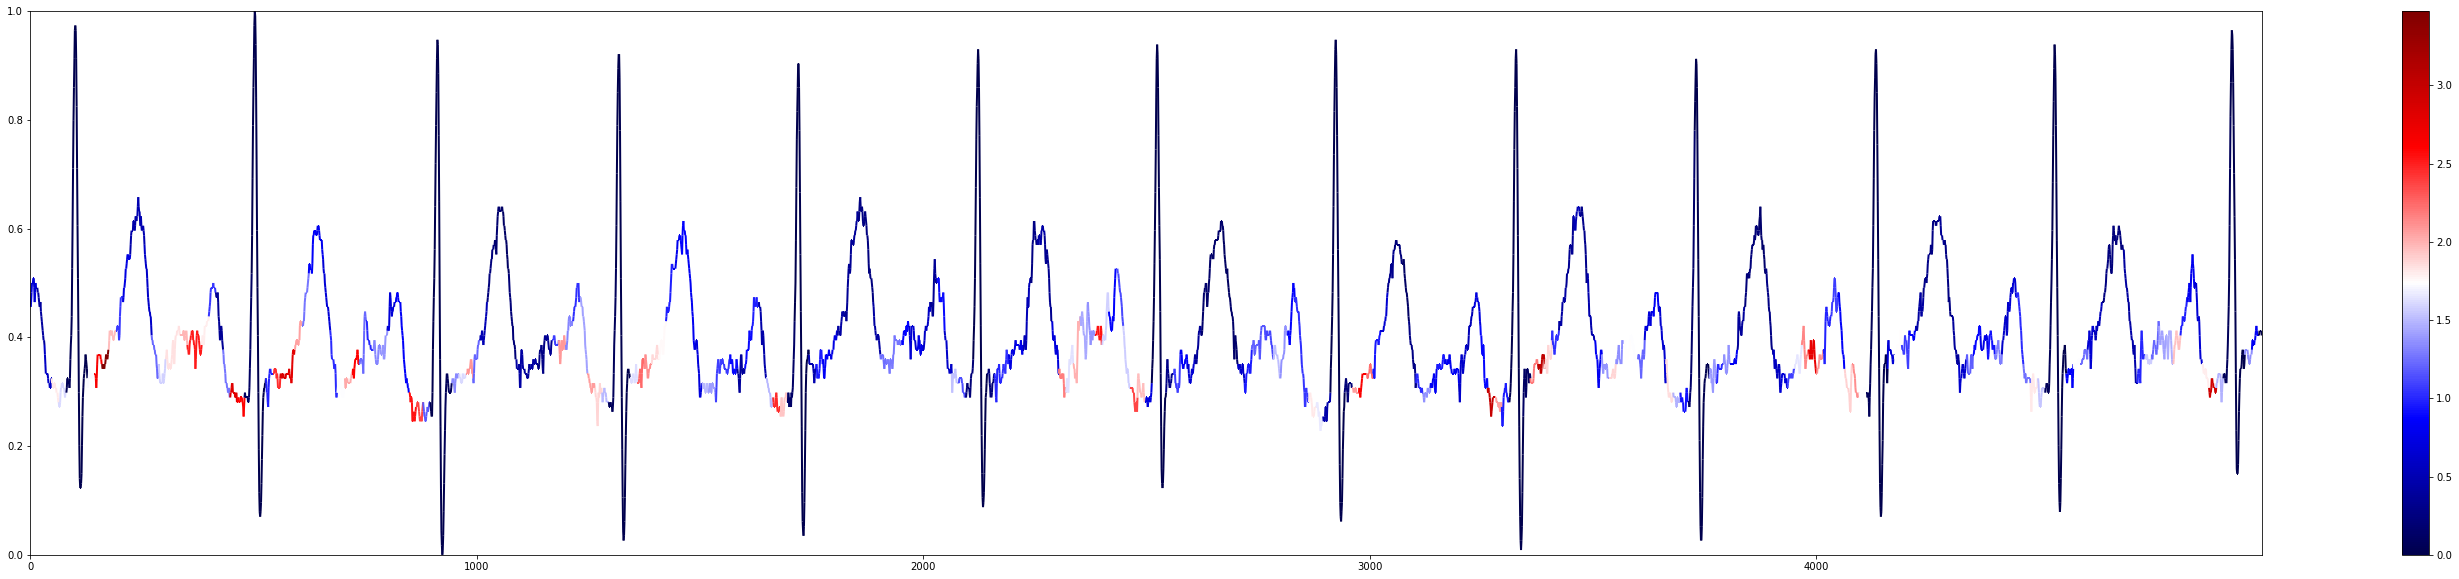

In [8]:
fig = plt.figure(figsize=(50,10))
ax = fig.add_subplot(1, 1, 1)
plot_y = (inputs[0,1,:].to('cpu')).detach().numpy()

ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value__each_timestep,cmap="seismic")
plt.show()